We start by importing the necessary libraries and the data functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Import our shared data loader functions
from data import fetch_aapl, fetch_bike_sharing

# Set plot style for better visuals
plt.style.use('seaborn-v0_8')

First, we look at why time series is unique: the order matters. We will compare Apple stock returns with a shuffled version of the same data to prove that shuffling destroys the predictive signal .

Original lag-1 autocorrelation: -0.1332
Shuffled lag-1 autocorrelation: 0.0002
Structure destroyed by shuffling: 0.1335


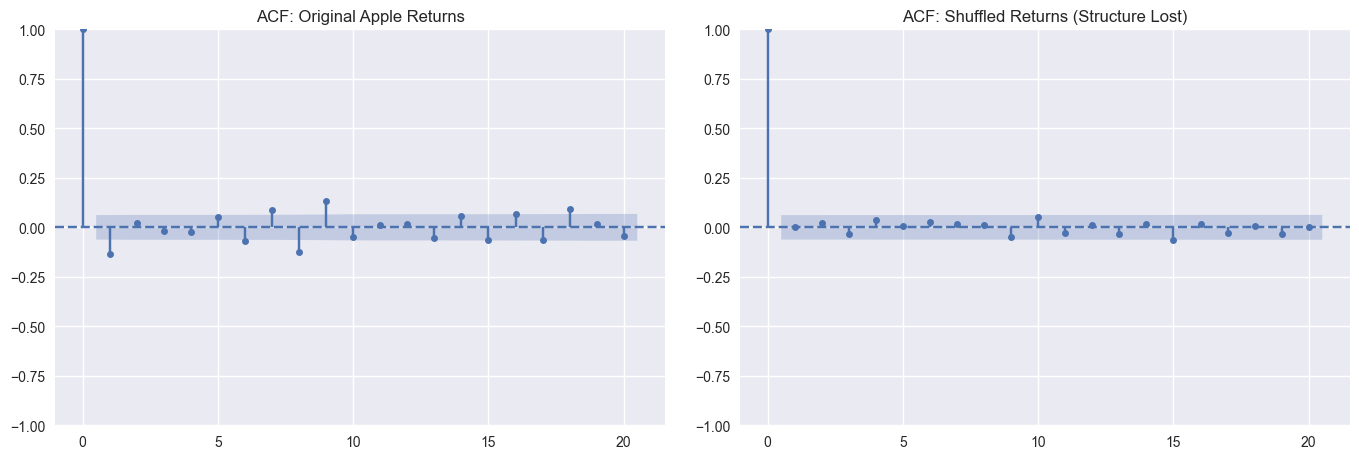

In [3]:
# Load Apple data
aapl = fetch_aapl()
aapl_returns = aapl['returns'].dropna()

# 1. Calculate autocorrelations
original_autocorr = aapl_returns.autocorr(lag=1)

# 2. Shuffle the data (destroying temporal order)
shuffled_returns = aapl_returns.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_autocorr = shuffled_returns.autocorr(lag=1)

print(f"Original lag-1 autocorrelation: {original_autocorr:.4f}")
print(f"Shuffled lag-1 autocorrelation: {shuffled_autocorr:.4f}")
print(f"Structure destroyed by shuffling: {abs(original_autocorr - shuffled_autocorr):.4f}")

# 3. Visual comparison using ACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(aapl_returns, lags=20, ax=axes[0], title='ACF: Original Apple Returns')
plot_acf(shuffled_returns, lags=20, ax=axes[1], title='ACF: Shuffled Returns (Structure Lost)')
plt.tight_layout()
plt.show()

To make the ACF actionable, we use a utility function that scans for significant lags and suggests a modeling strategy .

In [4]:
def analyze_autocorrelation_patterns(series, series_name, max_lags=20, alpha=0.05):
    """Simple ACF scan + text recommendations."""
    n = len(series)
    threshold = 1.96 / np.sqrt(n)
    acfs = [series.autocorr(lag=k) for k in range(1, max_lags+1)]
    sig = [(k, acf) for k, acf in enumerate(acfs, 1) if abs(acf) > threshold]

    # Build a clean summary
    summary = {
        "name": series_name,
        "n_lags_tested": max_lags,
        "n_significant": len(sig),
        "top_lags": sig[:3]
    }

    # Map to clear interpretations
    interpretations = []
    for lag, corr in summary["top_lags"]:
        if lag == 1:
            text = "Lag-1 momentum -> include lag-1 as feature"
        elif lag in (5, 7):
            text = f"Lag-{lag} seasonality -> try weekly/seasonal model"
        else:
            text = f"Lag-{lag} cycle -> craft custom lag-{lag} features"
        interpretations.append(f"  • Lag {lag}: ρ={corr:.3f} -> {text}")

    # Decide strategy
    if summary["n_significant"] == 0:
        strategy = "No clear autocorrelation -> focus on external/exogenous predictors."
    elif summary["n_significant"] <= 3:
        strategy = "Moderate autocorrelation -> a classical ARIMA model is probably sufficient."
    else:
        strategy = "Rich autocorrelation -> consider more flexible models or ML approaches."

    # Print output
    print(f"\nAutocorrelation Analysis: {summary['name']}")
    print(f"  Tested lags 1–{summary['n_lags_tested']}, found {summary['n_significant']} significant.")
    print("\nKey patterns:")
    print("\n".join(interpretations) if interpretations else "  • None")
    print(f"\nRecommended strategy:\n  -> {strategy}\n")
    
    return summary, interpretations, strategy

# Run the analysis
_ = analyze_autocorrelation_patterns(aapl_returns, "Apple Daily Returns")


Autocorrelation Analysis: Apple Daily Returns
  Tested lags 1–20, found 9 significant.

Key patterns:
  • Lag 1: ρ=-0.133 -> Lag-1 momentum -> include lag-1 as feature
  • Lag 6: ρ=-0.071 -> Lag-6 cycle -> craft custom lag-6 features
  • Lag 7: ρ=0.087 -> Lag-7 seasonality -> try weekly/seasonal model

Recommended strategy:
  -> Rich autocorrelation -> consider more flexible models or ML approaches.



Next, we examine stationarity. We compare the raw stock price (non-stationary) with the returns (stationary) using rolling statistics .

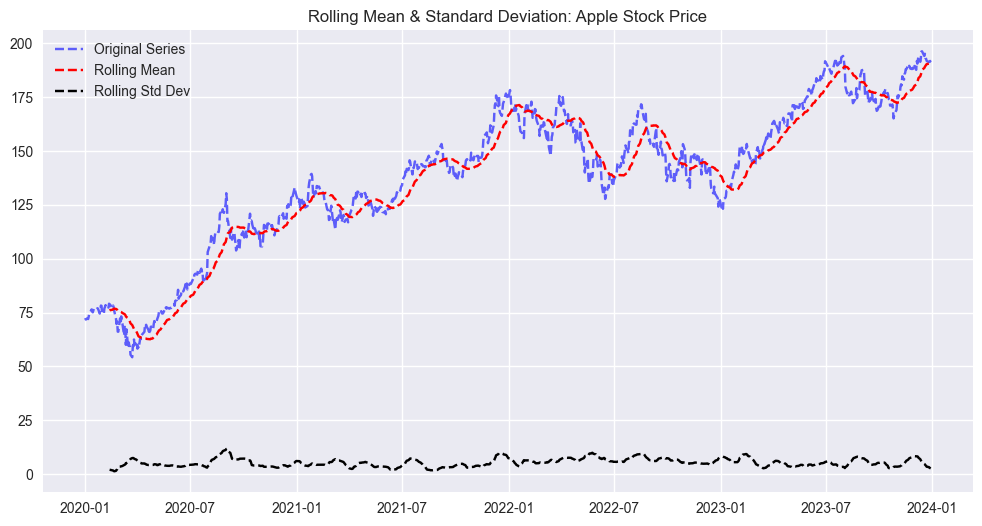

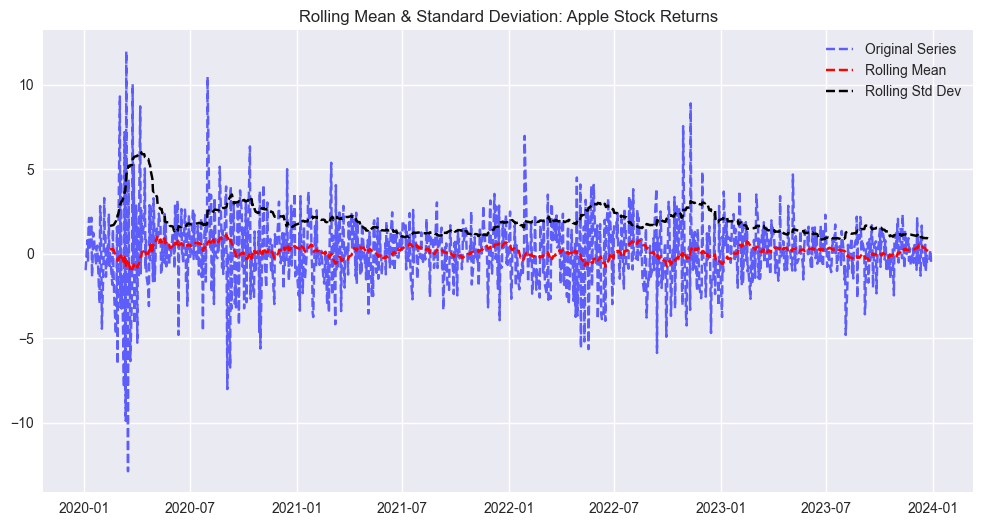

In [5]:
def plot_rolling_stats(series, title_suffix):
    """Plots a series with its rolling mean and standard deviation."""
    rolling_mean = series.rolling(window=30).mean()
    rolling_std = series.rolling(window=30).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, color='blue', label='Original Series', alpha=0.6)
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation: {title_suffix}')
    plt.show()

# Plot for non-stationary price level
plot_rolling_stats(aapl['Close'], 'Apple Stock Price')

# Plot for stationary returns
plot_rolling_stats(aapl['returns'].dropna(), 'Apple Stock Returns')

Visuals are good, but statistical tests (ADF and KPSS) are definitive. We define a function to run both tests simultaneously .

In [6]:
def run_stationarity_tests(series, series_name=""):
    """Runs and interprets ADF and KPSS tests."""
    print(f"--- Stationarity Tests for {series_name} ---")

    # ADF Test (Null: Non-stationary)
    adf_result = adfuller(series)
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print("ADF Conclusion: likely NON-STATIONARY." if adf_result[1] > 0.05 else "ADF Conclusion: likely STATIONARY.")
    
    print("\n")

    # KPSS Test (Null: Stationary)
    kpss_result = kpss(series, regression='c', nlags="auto")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print("KPSS Conclusion: likely NON-STATIONARY." if kpss_result[1] < 0.05 else "KPSS Conclusion: likely STATIONARY.")
    print("-" * 30 + "\n")

# Run tests on Price (expect Non-Stationary)
run_stationarity_tests(aapl['Close'].dropna(), "Apple Stock Price")

# Run tests on Returns (expect Stationary)
run_stationarity_tests(aapl['returns'].dropna(), "Apple Stock Returns")

--- Stationarity Tests for Apple Stock Price ---
ADF Statistic: -1.5120
p-value: 0.5276
ADF Conclusion: likely NON-STATIONARY.


KPSS Statistic: 3.9359
p-value: 0.0100
KPSS Conclusion: likely NON-STATIONARY.
------------------------------

--- Stationarity Tests for Apple Stock Returns ---
ADF Statistic: -10.1633
p-value: 0.0000
ADF Conclusion: likely STATIONARY.


KPSS Statistic: 0.1490
p-value: 0.1000
KPSS Conclusion: likely STATIONARY.
------------------------------



/var/folders/zs/dpjs6jdx52xgnf97mcsn19240000gp/T/ipykernel_41398/3256809682.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
/var/folders/zs/dpjs6jdx52xgnf97mcsn19240000gp/T/ipykernel_41398/3256809682.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


If a series is non-stationary, differencing is the primary fix. Here we show that differencing the price yields the same stationary result as calculating returns.

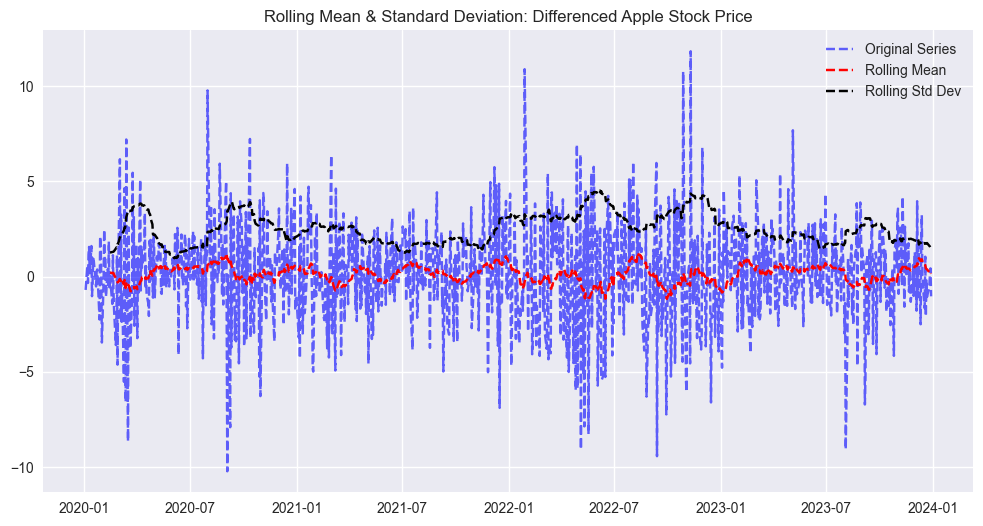

--- Stationarity Tests for Differenced Apple Stock Price ---
ADF Statistic: -32.9903
p-value: 0.0000
ADF Conclusion: likely STATIONARY.


KPSS Statistic: 0.0539
p-value: 0.1000
KPSS Conclusion: likely STATIONARY.
------------------------------



/var/folders/zs/dpjs6jdx52xgnf97mcsn19240000gp/T/ipykernel_41398/3256809682.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


In [7]:
# Apply first-order differencing to the price
aapl['price_diff'] = aapl['Close'].diff()

# Visualize
plot_rolling_stats(aapl['price_diff'].dropna(), 'Differenced Apple Stock Price')

# Confirm with tests
run_stationarity_tests(aapl['price_diff'].dropna(), "Differenced Apple Stock Price")

Finally, we break a complex series down into Trend, Seasonality, and Residuals. We compare three methods: Additive, Multiplicative, and STL (Seasonal-Trend Decomposition using LOESS).

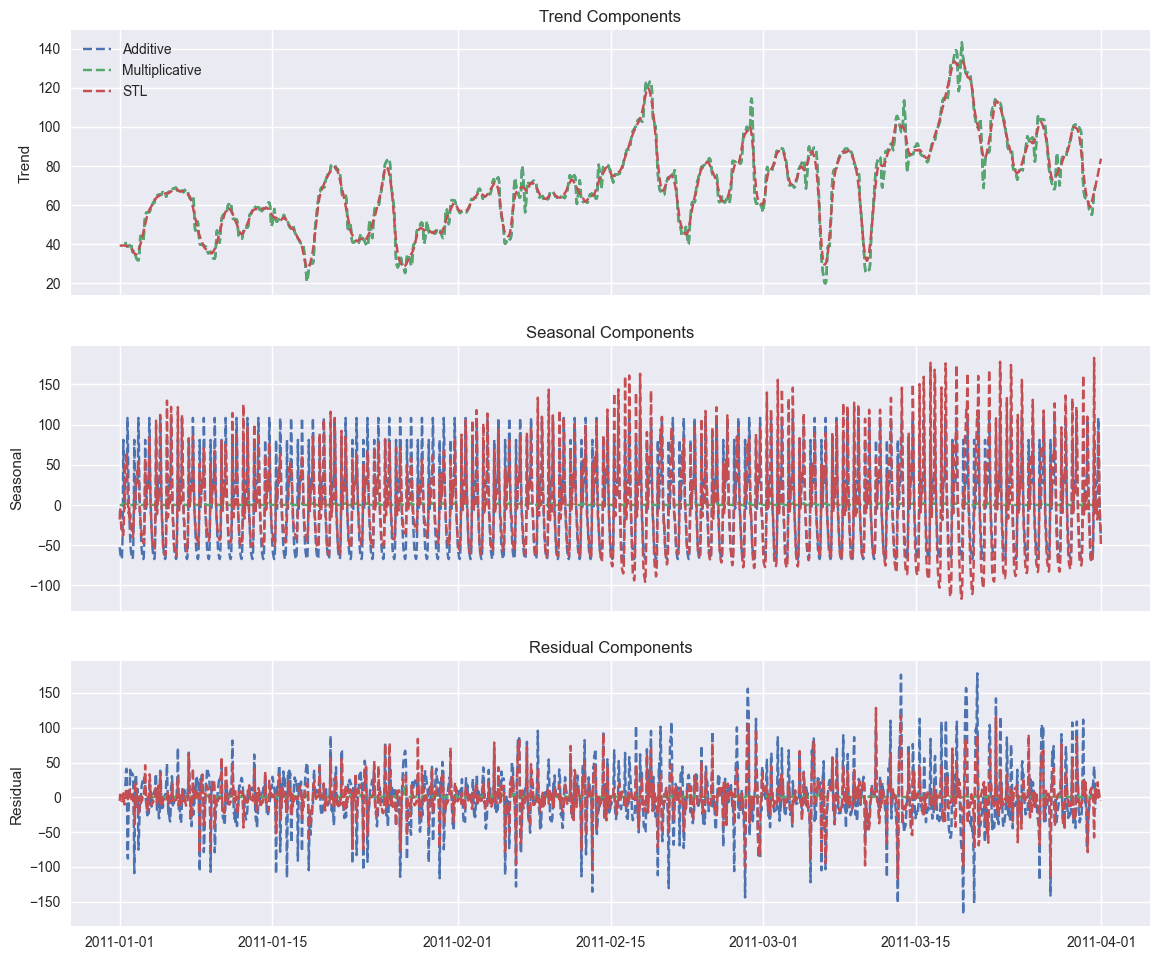

In [8]:
# 1. Load & prep Bike Data
df_bike = fetch_bike_sharing()
bike = df_bike['cnt'].asfreq('h').interpolate()
slice_ = bike['2011-01-01':'2011-03-31'] # Slice 3 months for better visibility

# 2. Compute decompositions
# Period=24 because we have hourly data with a daily cycle
add = seasonal_decompose(slice_, model='additive', period=24)
mult = seasonal_decompose(slice_, model='multiplicative', period=24)
stl = STL(slice_, period=24).fit()

# 3. Visualization Comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Trend
axes[0].plot(add.trend, label='Additive')
axes[0].plot(mult.trend, label='Multiplicative')
axes[0].plot(stl.trend, label='STL')
axes[0].set_ylabel('Trend')
axes[0].legend(loc='upper left')
axes[0].set_title('Trend Components')

# Seasonal
axes[1].plot(add.seasonal, label='Additive')
axes[1].plot(mult.seasonal, label='Multiplicative')
axes[1].plot(stl.seasonal, label='STL')
axes[1].set_ylabel('Seasonal')
axes[1].set_title('Seasonal Components')

# Residual
axes[2].plot(add.resid, label='Additive')
axes[2].plot(mult.resid, label='Multiplicative')
axes[2].plot(stl.resid, label='STL')
axes[2].set_ylabel('Residual')
axes[2].set_title('Residual Components')

plt.tight_layout()
plt.show()